In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from ml_utils.util import remove_empty_from_array

In [152]:
path2target = '/Users/y1u0d2/desktop/Lab/result/n2p2/Si/07/rc_5-np_9'

f_tests = glob.glob(f'{path2target}/testforces.*.out')
f_trains = glob.glob(f'{path2target}/trainforces.*.out')
e_tests = glob.glob(f'{path2target}/testpoints.*.out')
e_trains = glob.glob(f'{path2target}/trainpoints.*.out')

f_tests.sort()
f_trains.sort()
e_tests.sort()
e_trains.sort()

In [153]:
# path = f_tests[0]
# with open(path, mode='r') as f:
#     l_strip = [s.strip() for s in f.readlines()]

In [154]:
# columns = ['index_s', 'index_a', 'Fref', 'Fnnp']

# idx: int
# for i, l in enumerate(l_strip):
#     if (columns[0] in l) & (columns[1] in l) & (columns[2] in l) &(columns[3] in l):
#         idx = i
#         break
    
        

In [155]:
# from ml_utils.util import remove_empty_from_array
# rows = l_strip[idx+2:]
# rows = [remove_empty_from_array(row.split(' ')) for row in rows]

In [156]:
# df = pd.DataFrame(data=rows, columns=columns)

In [157]:
def get_idx_from_columns(columns, lines):
    """
    docstring
    """
    for i, l in enumerate(lines):
        flag = False
        judge_list = [column in l for column in columns]
        if all(judge_list):
            idx = i
            break
    return idx
    

def convert_forceout_to_df(path2file):
    """
    docstring
    """
    with open(path2file, mode='r') as f:
        l_strip = [s.strip() for s in f.readlines()]
        
    columns = ['index_s', 'index_a', 'Fref', 'Fnnp']
    idx = get_idx_from_columns(columns, lines=l_strip)
    rows = l_strip[idx+2:]
    rows = [remove_empty_from_array(row.split(' ')) for row in rows]
    df = pd.DataFrame(data=rows, columns=columns)
    return df


def convert_energyout_to_df(path2file):
    """
    docstring
    """
    with open(path2file, mode='r') as f:
        l_strip = [s.strip() for s in f.readlines()]
        
    columns = ['index', 'Eref', 'Ennp']
    idx = get_idx_from_columns(columns, lines=l_strip)
    rows = l_strip[idx+2:]
    rows = [remove_empty_from_array(row.split(' ')) for row in rows]
    df = pd.DataFrame(data=rows, columns=columns)
    return df

In [158]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def calc_score(ref, pred) -> dict:
    dic = {
        'R2': r2_score(ref, pred),
        'RMSE': np.sqrt(mean_squared_error(ref, pred)),
        'MAE': mean_absolute_error(ref, pred)
    }
    return dic

def calc_force_score(epoch, data_type, force_df: pd.DataFrame)-> dict:
    ref, pred = force_df['Fref'], force_df['Fnnp']
    dic = calc_score(ref, pred)
    dic['epoch'] = epoch
    dic['data_type'] = data_type
    dic['type'] = 'force'
    return dic

def calc_energy_score(epoch, data_type, energy_df: pd.DataFrame) -> dict:
    ref, pred = energy_df['Eref'], energy_df['Ennp']
    dic = calc_score(ref, pred)
    dic['epoch'] = epoch
    dic['data_type'] = data_type
    dic['type'] = 'energy'
    return dic

In [159]:
def get_epoch(path):
    return path.split('/')[-1].split('.')[1]

def validate_epoch_file(f_test, f_train, e_test, e_train):
    if get_epoch(f_test) == get_epoch(f_train) == get_epoch(e_test) == get_epoch(e_train):
        return True
    else:
        return False
    
all_score_dict = {}
for i, (f_test, f_train, e_test, e_train) in  enumerate(zip(f_tests, f_trains, e_tests, e_trains)):
    if validate_epoch_file(f_test, f_train, e_test, e_train):
        epoch = int(get_epoch(f_test))
        f_test_score = calc_force_score(epoch=epoch, data_type='test', force_df=convert_forceout_to_df(f_test))
        f_train_score = calc_force_score(epoch=epoch, data_type='train', force_df=convert_forceout_to_df(f_train))
        e_test_score = calc_energy_score(epoch=epoch, data_type='test', energy_df=convert_energyout_to_df(e_test))
        e_train_score = calc_energy_score(epoch=epoch, data_type='train', energy_df=convert_energyout_to_df(e_train))
        idx_start = 4*i
        all_score_dict[idx_start] = f_test_score
        all_score_dict[idx_start+1] = f_train_score
        all_score_dict[idx_start+2] = e_test_score
        all_score_dict[idx_start+3] = e_train_score


In [160]:
score_df = pd.DataFrame.from_dict(all_score_dict, orient='index')

In [170]:
force_score_test= score_df.loc[(score_df['type'] == 'force') & (score_df['data_type'] == 'test')]
force_score_train= score_df.loc[(score_df['type'] == 'force') & (score_df['data_type'] == 'train')]

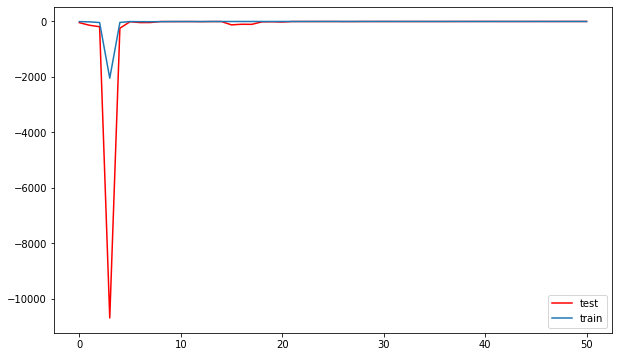

In [173]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(force_score_test['epoch'], force_score_test['R2'], label='test', color='red')
ax.plot(force_score_train['epoch'], force_score_train['R2'], label='train')
ax.legend()

In [3]:
from analyze.get_score_df import get_all_score_df

path2target = '/Users/y1u0d2/desktop/Lab/result/n2p2/Si/07/rc_5-np_9'
score_df = get_all_score_df(path2target)